网点现金预测建模 Baseline
数据样本背景：佛山三水一住宅区附近网点，整体交易量在网点中属于中下水平
样本数据集：20180101-2020-05-31
验证数据集：20200602

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
#读取数据，数据
tmp_df = pd.read_csv('./iml_txn_dpst_fin_dtl_e_casestudy.csv')

tmp_df['date'] = pd.to_datetime(tmp_df['pass_acct_dt'], format='%Y%m%d')
tmp_df.set_index('date', inplace=True)
tmp_df.head()

,pass_acct_dt,prest_txn_tm,txn_amt
date,,,
2019-07-13,20190713,10514868,150.0
2019-07-13,20190713,10320728,50.0
2019-07-13,20190713,11170684,-54670.0
2019-07-13,20190713,13415506,-56220.0
2019-07-13,20190713,11202778,50.0


In [94]:
tmp_df_not0 = tmp_df.loc[tmp_df['prest_txn_tm']!=0]
tmp_df_not0.describe()

,pass_acct_dt,prest_txn_tm,txn_amt
count,2.607570e+05,2.607570e+05,2.607570e+05
mean,2.018767e+07,1.314242e+07,-4.852486e+03
std,7.282682e+03,3.922385e+06,2.754027e+05
min,2.018010e+07,2.880000e+02,-4.900000e+07
25%,2.018071e+07,1.045573e+07,-3.000000e+03
50%,2.019012e+07,1.331493e+07,-1.000000e+01
75%,2.019092e+07,1.607244e+07,9.000000e+02
max,2.020082e+07,2.359595e+07,1.650000e+07


In [95]:
tmp_df_0 = tmp_df.loc[tmp_df['prest_txn_tm']==0]
tmp_df_0.describe()

,pass_acct_dt,prest_txn_tm,txn_amt
count,1.277320e+05,127732.0,1.277320e+05
mean,2.018497e+07,0.0,7.956580e+04
std,4.720357e+03,0.0,2.076559e+06
min,2.018010e+07,0.0,-3.268584e+07
25%,2.018083e+07,0.0,1.413150e+02
50%,2.018121e+07,0.0,1.776230e+03
75%,2.019032e+07,0.0,1.214998e+04
max,2.019063e+07,0.0,1.342836e+08


date
2018-01-01     -18988.00
2018-01-02    -281282.57
2018-01-03     518396.94
2018-01-04    -570381.66
2018-01-05   -3269533.09
Name: txn_amt, dtype: float64

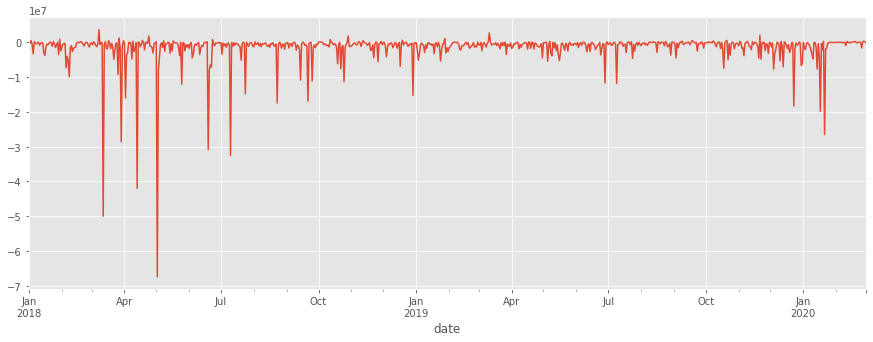

In [98]:
cash_flow_d = tmp_df_not0.groupby(['date'])['txn_amt'].sum()
plt.style.use('ggplot')
fig = plt.subplots(figsize=(15,5))
cash_flow_d[:'2020-02-29'].plot()
cash_flow_d.head()

In [65]:
cash_flow_train = cash_flow_d[:'2020-02-29']
cash_flow_train_diff = cash_flow_train.diff(1).fillna(0)

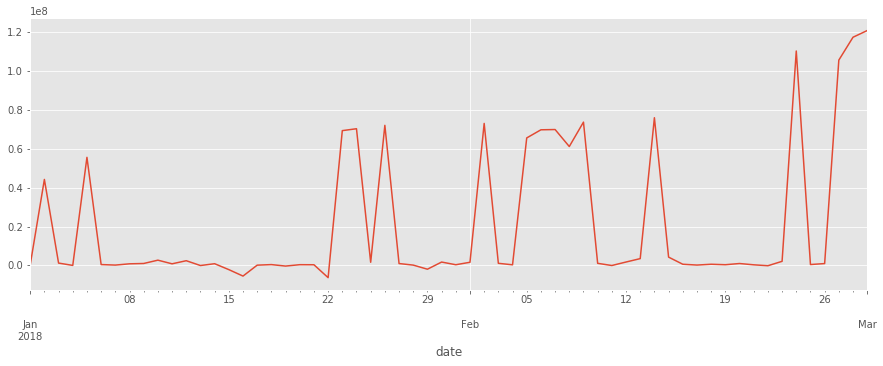

In [74]:
plt.style.use('ggplot')
fig = plt.subplots(figsize=(15,5))
cash_flow_train['2018-01-01':'2018-03-01'].plot()

In [64]:
from statsmodels.tsa.stattools import adfuller as ADF
ADF(cash_flow_d[:'2020-02-29'])

(-1.9837423353531258,
 0.2937466966683647,
 20,
 769,
 {'1%': -3.438882201132452,
  '5%': -2.865305765357574,
  '10%': -2.568775270215655},
 28102.85822916092)

In [66]:
ADF(cash_flow_train_diff)

(-9.737660643367713,
 8.663077214902687e-17,
 21,
 768,
 {'1%': -3.4388933482333464,
  '5%': -2.8653106782623574,
  '10%': -2.5687778874376086},
 28093.606481875257)

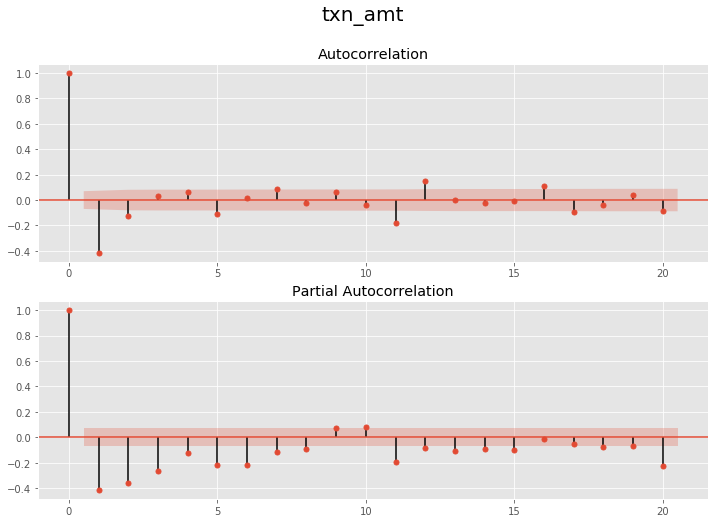

In [70]:
import statsmodels.api as sm

def autocorrelation(timeseries, lags):
    fig = plt.figure(figsize=(12, 8))
    plt.suptitle(timeseries.name, fontsize=20)
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()
    
autocorrelation(cash_flow_train_diff, 20)

In [55]:
def count_deposit_ratios(df, baseline):
    total = df.loc[df['txn_amt']>0].count()
    count = df.loc[df['txn_amt']>baseline].count()
    percentage = count/total
    print('total:{}, count:{}, percentage:{}'.format(total, count, percentage))
    return percentage
count_deposit_ratios(tmp_df, 500000)


total:pass_acct_dt    243599
prest_txn_tm    243599
txn_amt         243599
dtype: int64, count:pass_acct_dt    2880
prest_txn_tm    2880
txn_amt         2880
dtype: int64, percentage:pass_acct_dt    0.011823
prest_txn_tm    0.011823
txn_amt         0.011823
dtype: float64


pass_acct_dt    0.011823
prest_txn_tm    0.011823
txn_amt         0.011823
dtype: float64

In [56]:
deposit_seq = [5000,10000,50000,100000,500000,1000000]
percentages = []
for deposit in deposit_seq:
    percentages.append(count_deposit_ratios(tmp_df, deposit))

print(percentages)
    

total:pass_acct_dt    243599
prest_txn_tm    243599
txn_amt         243599
dtype: int64, count:pass_acct_dt    79408
prest_txn_tm    79408
txn_amt         79408
dtype: int64, percentage:pass_acct_dt    0.325978
prest_txn_tm    0.325978
txn_amt         0.325978
dtype: float64
total:pass_acct_dt    243599
prest_txn_tm    243599
txn_amt         243599
dtype: int64, count:pass_acct_dt    51371
prest_txn_tm    51371
txn_amt         51371
dtype: int64, percentage:pass_acct_dt    0.210883
prest_txn_tm    0.210883
txn_amt         0.210883
dtype: float64
total:pass_acct_dt    243599
prest_txn_tm    243599
txn_amt         243599
dtype: int64, count:pass_acct_dt    20140
prest_txn_tm    20140
txn_amt         20140
dtype: int64, percentage:pass_acct_dt    0.082677
prest_txn_tm    0.082677
txn_amt         0.082677
dtype: float64
total:pass_acct_dt    243599
prest_txn_tm    243599
txn_amt         243599
dtype: int64, count:pass_acct_dt    11660
prest_txn_tm    11660
txn_amt         11660
dtype: int6

In [ ]:
tmp_df

In [35]:
cash_flow_daily = pd.DataFrame(tmp_df.groupby(['date'])['txn_amt'].sum())
cash_flow_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 963 entries, 2018-01-01 to 2020-08-20
Data columns (total 1 columns):
txn_amt    963 non-null float64
dtypes: float64(1)
memory usage: 15.0 KB


In [36]:
cash_flow_daily.tail()

,txn_amt
date,
2020-08-16,12619.27
2020-08-17,-189570.38
2020-08-18,182505.08
2020-08-19,207034.19
2020-08-20,-86638.55


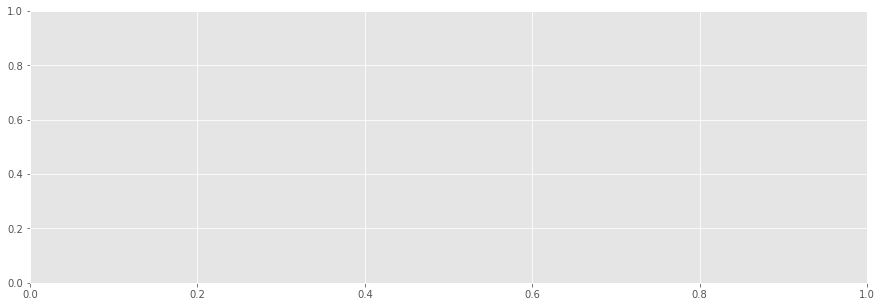

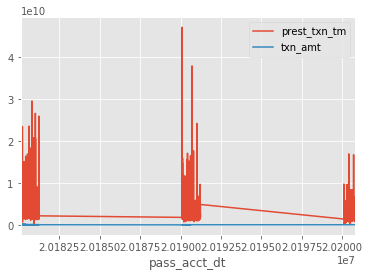

In [16]:
plt.style.use('ggplot')
fig = plt.subplots(figsize=(15, 5))
cash_flow_daily.plot()
plt.show()


In [4]:
cash_flow_daily.head(20)

,prest_txn_tm,txn_amt
pass_acct_dt,,
20180101,2177907508,246352.73
20180102,4860136319,44174467.69
20180103,3592016709,1229238.64
20180104,3041112843,40340.18
20180105,3293772478,55524398.38
20180106,2662529809,464680.48
20180107,1800502188,203680.59
20180108,10921885639,849726.78
20180109,3595437626,1019996.38
